In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Regulation

## Banking
### Inflation

In [2]:
df = pd.read_csv("../raw_data/government/inflation_data.csv")
df.head()

,year,amount,inflation rate
0,1912,1.00,0.02
1,1913,1.02,0.02
2,1914,1.03,0.01
3,1915,1.04,0.01
4,1916,1.12,0.08


### Consumer Price Index (CPI)
Raw data pulled from [here](https://data.bls.gov/timeseries/CUUR0000SA0?years_option=all_years) 

In [3]:
cpi_data = pd.read_excel("../raw_data/government/cpi.xlsx", header=11).drop(columns=["HALF1", "HALF2"])
cpi_data = pd.melt(cpi_data, id_vars=["Year"], var_name="Month", value_name="CPI")

# Convert abbreviated month to int; combine into single data column
cpi_data["Month"] = pd.to_datetime(cpi_data['Month'], format='%b').dt.month
cpi_data["Date"] = pd.to_datetime(cpi_data[["Year", "Month"]].assign(DAY=1))
cpi_data = cpi_data.sort_values(by="Date").reset_index(drop=True)

/home/jordan/python_environments/caml/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


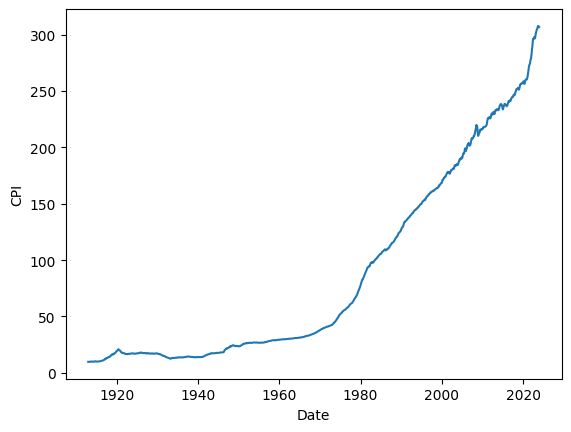

In [4]:
sns.lineplot(x="Date", y="CPI", data=cpi_data);

### Money Supply

In [5]:
df = pd.read_csv("../raw_data/government/money_supply_m2.csv")
df["Date"] = pd.to_datetime(df["Date"], format="mixed")
df.head()

,Date,Billions of Dollars
0,1959-01-01,286.6
1,1959-02-01,287.7
2,1959-03-01,289.2
3,1959-04-01,290.1
4,1959-05-01,292.2


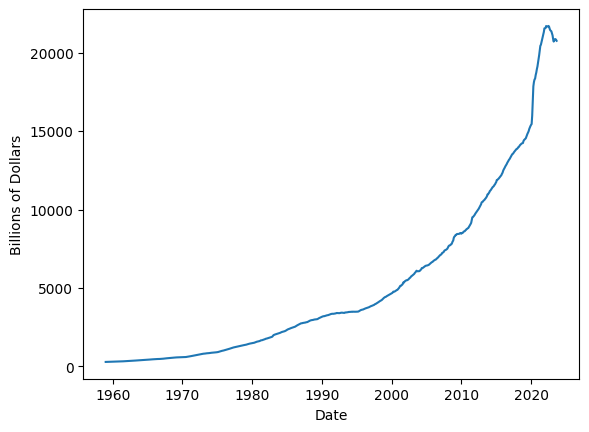

In [6]:
sns.lineplot(x="Date", y="Billions of Dollars", data=df);

## Aviation
### Commercial Aviation Fatalities Over Time
Raw data pulled from [here](https://en.wikipedia.org/wiki/List_of_fatal_accidents_and_incidents_involving_commercial_aircraft_in_the_United_States)

In [7]:
df = pd.read_csv("../raw_data/government/List_of_fatal_accidents_and_incidents_involving_commercial_aircraft_in_the_United_States.csv", sep="\t")
df["Date"] = pd.to_datetime(df["Date"], format="mixed")
df["Fatalities"] = df["Fatalities"].replace(",", "").astype(float)

# Remove September 11th flights
df = df[df["Date"] != "2001-09-11"]
df.head()

,Date,Fatalities,Injuries,Survivors,Flight(s) or incident,Location,State or territory,Aircraft,Summary
0,2023-06-23,1.0,0,0,2023 San Antonio ground crew suicide incident,San Antonio,Texas,Airbus A319,A ground crewman was ingested into an engine o...
1,2022-12-31,1.0,0,0,2022 Montgomery ground crew incident,Montgomery,Alabama,Embraer 175,An airline worker was pulled into the engine o...
2,2022-09-04,10.0,0,0,2022 Mutiny Bay DHC-3 Otter crash,Mutiny Bay near Whidbey Island,Washington,de Havilland Canada DHC-3 Otter,"Carrying tourists, the seaplane nosedived and ..."
3,2020-05-07,1.0,0,58,Southwest Airlines Flight 1392,Austin,Texas,Boeing 737-700,A man who had illegally entered the airfield w...
4,2020-01-26,9.0,0,0,2020 Calabasas helicopter crash,Calabasas,California,Sikorsky S-76B,The chartered helicopter flight crashed in hea...


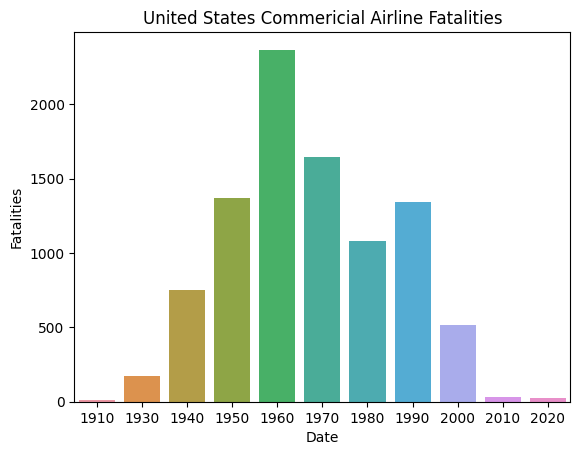

In [8]:
fatalities_per_decade = df["Fatalities"].groupby((df["Date"].dt.year//10)*10).sum().reset_index()
# fatalities_per_year = df["Fatalities"].groupby(df["Date"].dt.year).sum().reset_index()
plt.title("United States Commericial Airline Fatalities")
sns.barplot(x="Date", y="Fatalities", data=fatalities_per_decade);

### Commercial Airplane Speeds Over Time
Data was manually collected

In [9]:
df = pd.read_csv("../raw_data/government/commercial_airplane_speeds.txt")
df.head()

,Plane,Year,Cruise Speed,Top Speed,Source
0,Boeing 247,1933,189,200,https://g.co/kgs/76ALY6
1,Douglas DC-3,1935,207,257,https://g.co/kgs/hTVUaT
2,Douglas DC-4,1942,227,280,https://g.co/kgs/estQje
3,Lockhead 749,1947,275,347,https://aeropedia.com.au/content/lockheed-l-7...
4,Boeing 707,1958,604,627,https://en.wikipedia.org/wiki/Boeing_707


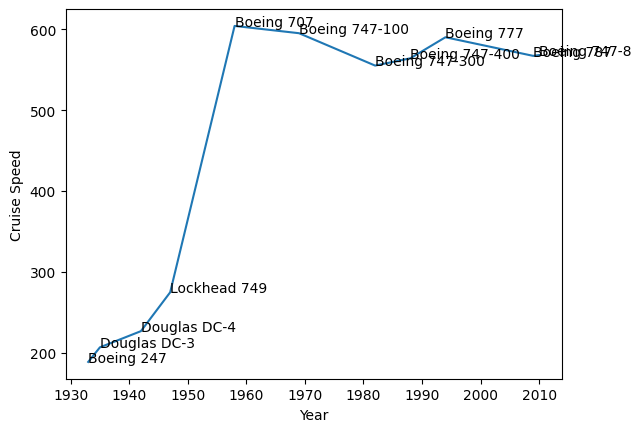

In [10]:
axes = sns.lineplot(x="Year", y="Cruise Speed", data=df)

for _, row in df.iterrows():
    axes.text(row.Year, row["Cruise Speed"], row.Plane)

## Education
### College Tuition
Raw data pulled from [here](https://data.bls.gov/timeseries/CUUR0000SEEB01?output_view=data)

In [11]:
data = pd.read_excel("../raw_data/government/college_tuition_and_fees.xlsx", header=11).drop(columns=["HALF1", "HALF2"])
data = pd.melt(data, id_vars=["Year"], var_name="Month", value_name="Value")

# Convert abbreviated month to int; combine into single data column
data["Month"] = pd.to_datetime(data['Month'], format='%b').dt.month
data["Date"] = pd.to_datetime(data[["Year", "Month"]].assign(DAY=1))
data = data.sort_values(by="Date").reset_index(drop=True)

# Ignore the first row with NaN
data = data.iloc[12:]

start = data["Value"].values[0]
data["Percent Change"] = 100 * (data["Value"] - start) / start

/home/jordan/python_environments/caml/lib/python3.8/site-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [12]:
# Compute CPI relative to 1978 to match tuition data
index = cpi_data[cpi_data.Date == "1978-01-01"].index[0]
cpi_relative_to_1978 = cpi_data.iloc[index:].copy()

start = cpi_relative_to_1978["CPI"].values[0]
cpi_relative_to_1978["Percent Change"] = 100 * (cpi_relative_to_1978["CPI"] - start) / start

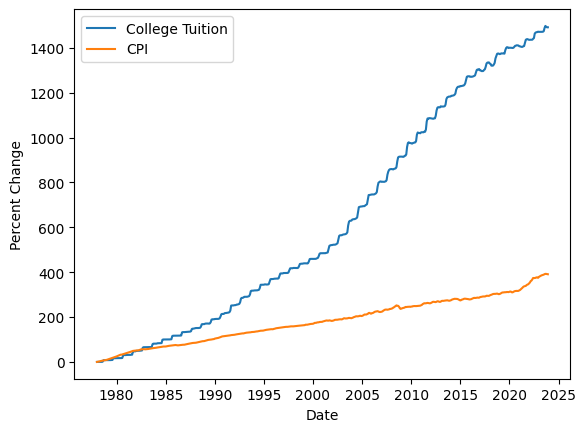

In [13]:
sns.lineplot(x="Date", y="Percent Change", data=data, label="College Tuition")
sns.lineplot(x="Date", y="Percent Change", data=cpi_relative_to_1978, label="CPI");

## Railroads
### Passenger Train Spees

In [14]:
df = pd.read_csv("../raw_data/government/passenger_train_speeds.txt")
df["Date"] = pd.to_datetime(df["Date"], format="mixed")
df.head()

,Km/H,MPH,Train,Location,Date,Comments,Country
0,200.0,120,Class 1000 Shinkansen,Kamonomiya test track in Odawara now part of T...,1962-10-31,NaN,Japan
1,256.0,159,Class 1000 Shinkansen,Kamonomiya test track,1963-03-30,Former world speed record for EMU trains.,Japan
2,286.0,178,Class 951 Shinkansen,San'yō Shinkansen,1972-02-24,Former world speed record for EMU trains.,Japan
3,319.0,198,Class 961 Shinkansen,Oyama test track now part of Tōhoku Shinkansen,1979-12-07,Former world speed record for EMU trains.,Japan
4,326.0,203,300 series,Tōkaidō Shinkansen,1991-02-28,NaN,Japan


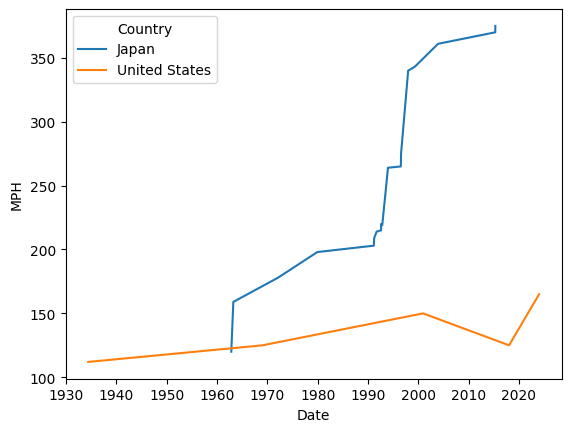

In [15]:
axes = sns.lineplot(x="Date", y="MPH", data=df, hue="Country")